In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor

from drtester import DRtester

### Generate Data

In [2]:
np.random.seed(123)

N = 10000 # number of units
K =  5 # number of covariates

# Generate random Xs
X_mu = np.zeros(5) # Means of Xs
# Random covariance matrix of Xs
X_sig = np.diag(np.random.rand(5))
# X_sig = np.random.rand(5, 5)
# X_sig = np.dot(X_sig, X_sig.transpose())
X = st.multivariate_normal(X_mu, X_sig).rvs(N)

# Effect of Xs on outcome
X_beta = np.random.uniform(0, 5, K)
# Effect of treatment on outcomes
D_beta = np.array([0, 1, 2])
# Effect of treatment on outcome conditional on X1
DX1_beta = np.array([0, 0, 3])

# Generate 3 treatments (randomly assigned, equal probability)
D1 = np.random.uniform(0, 1, N)
D = np.where(D1 <= 1/3, 0, np.where(D1 > 2/3,2, 1))
D_dum = pd.get_dummies(D)

# Generate Y (based on X, D, and random noise)
Y_sig = 1 # Variance of random outcome noise
Y = X @ X_beta + (D_dum @ D_beta) + X[:, 1] * (D_dum @ DX1_beta) + np.random.normal(0, Y_sig, N)
Y = Y.to_numpy()

In [3]:
# Split to training and validation
train_prop = .5
train_N = np.ceil(train_prop * N)
ind = np.array(range(N))
train_ind = np.random.choice(N, int(train_N), replace = False)
val_ind = ind[~np.isin(ind, train_ind)]

Xtrain, Dtrain, Ytrain = X[train_ind], D[train_ind], Y[train_ind]
Xval, Dval, Yval = X[val_ind], D[val_ind], Y[val_ind]

del X, D, Y

### Validation

In [4]:
# Simple classifier and regressor for propensity, outcome, and cate
reg_t = RandomForestClassifier()
reg_y = GradientBoostingRegressor()
reg_cate = GradientBoostingRegressor()

In [5]:
my_dr_tester = DRtester(reg_y, reg_t).fit_nuisance(Xval, Dval, Yval, Xtrain, Dtrain, Ytrain)

In [6]:
Ztrain = Xtrain[:, 1]
Zval = Xval[:, 1]
my_dr_tester = my_dr_tester.fit_cate(reg_cate, Zval, Ztrain)

In [7]:
my_dr_tester = my_dr_tester.evaluate_all()

In [9]:
print(my_dr_tester.df_res)

   blp_est  blp_se  blp_pval  cal_r_squared
1   -0.043   0.060     0.474         -1.020
2    0.820   0.096     0.000          0.892


<Axes: title={'center': 'Treatment = 2, Calibration R^2 = 0.892'}, xlabel='Group Mean CATE', ylabel='GATE'>

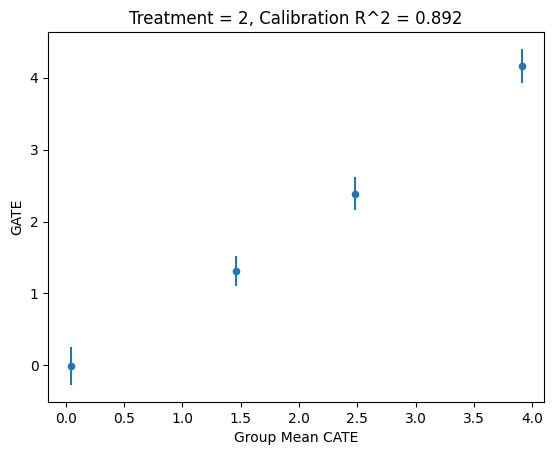

In [14]:
my_dr_tester.plot_cal(2)

In [16]:
my_dr_tester = DRtester(reg_y, reg_t).fit_nuisance(Xval, Dval, Yval)

Ztrain = Xtrain[:, 1]
Zval = Xval[:, 1]
my_dr_tester = my_dr_tester.fit_cate(reg_cate, Zval)

In [17]:
my_dr_tester = my_dr_tester.fit_cate(reg_cate, Zval, Ztrain)

Exception: Nuisance models fit fit (cv) in validation sample but Ztrain is specified

In [20]:
my_dr_tester.evaluate_blp().blp_res

,blp_est,blp_se,blp_pval
1,-0.097,0.063,0.126
2,0.726,0.068,0.000


In [27]:
my_dr_tester.evaluate_cal()

Exception: Must fit nuisance/CATE models on training sample data to use calibration test